## TASK 02

In [1]:
# Download required libraries
!pip install yfinance tensorflow

In [2]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras import Input
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import yfinance as yf  # For downloading stock data

In [3]:
# 1. Data Collection
def download_stock_data(ticker, start_date, end_date):
    """Download historical stock data from Yahoo Finance"""
    data = yf.download(ticker, start=start_date, end=end_date)
    return data

# Download Apple stock data as an example
stock_data = download_stock_data('AAPL', '2010-01-01', '2023-12-31')
print(stock_data.head())

C:\Users\PMLS\AppData\Local\Temp\ipykernel_7744\103490696.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

Price          Close      High       Low      Open     Volume
Ticker          AAPL      AAPL      AAPL      AAPL       AAPL
Date                                                         
2010-01-04  6.431896  6.446622  6.382907  6.414464  493729600
2010-01-05  6.443017  6.479383  6.409055  6.449629  601904800
2010-01-06  6.340533  6.468564  6.333921  6.443018  552160000
2010-01-07  6.328810  6.371487  6.282827  6.363974  477131200
2010-01-08  6.370887  6.371489  6.283130  6.320396  447610800


In [4]:
# 2. Data Preprocessing
def preprocess_data(data, look_back=60):
    """
    Prepare data for modeling:
    - Normalize features
    - Create sequences for time series prediction
    - Split into features and target
    """
    # Select relevant features
    features = data[['Open', 'High', 'Low', 'Close', 'Volume']]
    
    # Normalize the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(features)
    
    # Create sequences for time series prediction
    X, y = [], []
    for i in range(look_back, len(scaled_data)):
        X.append(scaled_data[i-look_back:i, :])
        y.append(scaled_data[i, 3])  # Predicting 'Close' price
    
    X, y = np.array(X), np.array(y)
    
    # Split into train and test sets (80-20 split)
    split = int(0.8 * len(X))
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]
    
    return X_train, X_test, y_train, y_test, scaler

X_train, X_test, y_train, y_test, scaler = preprocess_data(stock_data)

In [5]:
# 3. Random Forest Model
def build_random_forest(X_train, y_train):
    """Build and train a Random Forest model"""
    # Reshape data for RF (flatten the time steps)
    n_samples, n_timesteps, n_features = X_train.shape
    X_train_flat = X_train.reshape((n_samples, n_timesteps * n_features))
    
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train_flat, y_train)
    return model

rf_model = build_random_forest(X_train, y_train)


Model Evaluation (RF):
MSE: 0.023488
MAE: 0.123352
R2 Score: -1.3721


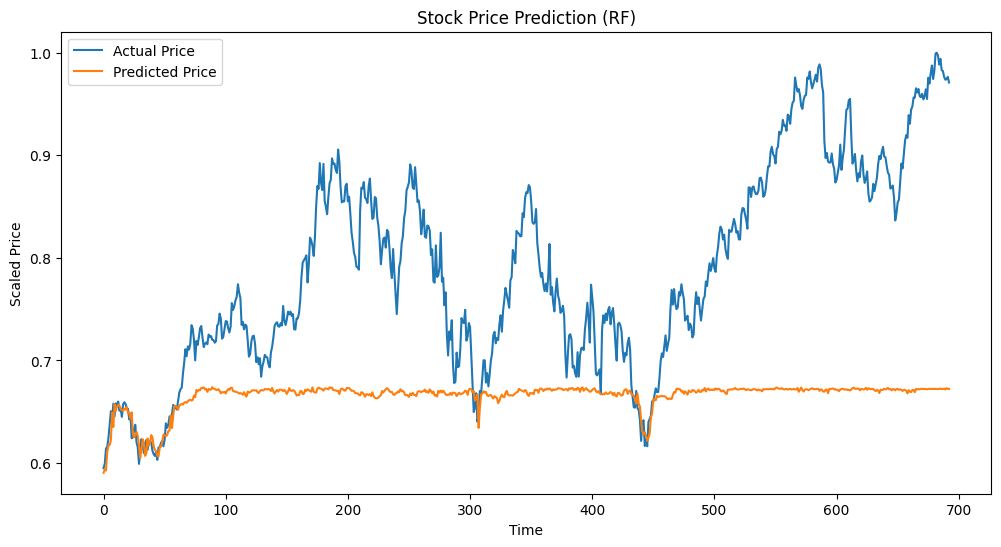

In [6]:

# Evaluate RF model
def evaluate_model(model, X_test, y_test, model_type='rf'):
    """Evaluate model performance"""
    if model_type == 'rf':
        n_samples, n_timesteps, n_features = X_test.shape
        X_test_flat = X_test.reshape((n_samples, n_timesteps * n_features))
        y_pred = model.predict(X_test_flat)
    else:
        y_pred = model.predict(X_test)
        y_pred = y_pred.reshape(-1)
    
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"\nModel Evaluation ({model_type.upper()}):")
    print(f"MSE: {mse:.6f}")
    print(f"MAE: {mae:.6f}")
    print(f"R2 Score: {r2:.4f}")
    
    # Plot predictions vs actual
    plt.figure(figsize=(12, 6))
    plt.plot(y_test, label='Actual Price')
    plt.plot(y_pred, label='Predicted Price')
    plt.title(f'Stock Price Prediction ({model_type.upper()})')
    plt.xlabel('Time')
    plt.ylabel('Scaled Price')
    plt.legend()
    plt.show()
    
    return y_pred

rf_pred = evaluate_model(rf_model, X_test, y_test, 'rf')

In [7]:
# 4. LSTM Model
def build_lstm_model(input_shape):
    """Build and compile an LSTM model using the recommended approach"""
    # Define input layer
    inputs = Input(shape=input_shape)
    
    # First LSTM layer
    x = LSTM(50, return_sequences=True)(inputs)
    x = Dropout(0.2)(x)
    
    # Second LSTM layer
    x = LSTM(50, return_sequences=False)(x)
    x = Dropout(0.2)(x)
    
    # Dense layers
    x = Dense(25)(x)
    outputs = Dense(1)(x)
    
    # Create model
    model = Model(inputs=inputs, outputs=outputs)
    
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Build the model
lstm_model = build_lstm_model((X_train.shape[1], X_train.shape[2]))

# Show model summary
lstm_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 60, 5)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 60, 50)              │          11,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,701 (127.74 KB)

 Trainable params: 32,701 (127.74 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Train LSTM model
early_stop = EarlyStopping(monitor='val_loss', patience=5)
history = lstm_model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=50,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 12s 66ms/step - loss: 0.0026 - val_loss: 0.0043
Epoch 2/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - loss: 6.5194e-04 - val_loss: 0.0158
Epoch 3/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - loss: 4.5772e-04 - val_loss: 0.0022
Epoch 4/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - loss: 5.2185e-04 - val_loss: 0.0032
Epoch 5/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - loss: 4.2145e-04 - val_loss: 8.5119e-04
Epoch 6/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 3.7141e-04 - val_loss: 0.0011
Epoch 7/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - loss: 2.8998e-04 - val_loss: 7.8414e-04
Epoch 8/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - loss: 2.9712e-04 - val_loss: 8.5683e-04
Epoch 9/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 3.2175e-04 - val_loss: 0.0012
Epoch 10/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - loss: 2.9102e-04 - val_loss: 0.0028
Epoch 11/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - loss: 3.0114e-04 - val_loss: 0.0031
Epoch 12/5

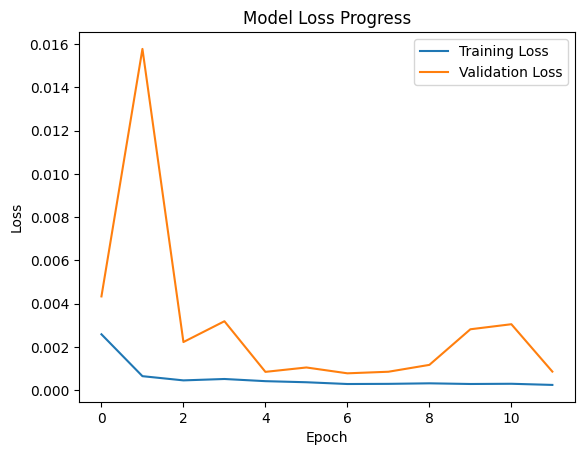

In [9]:
# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Progress')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step  

Model Evaluation (LSTM):
MSE: 0.000864
MAE: 0.023952
R2 Score: 0.9128


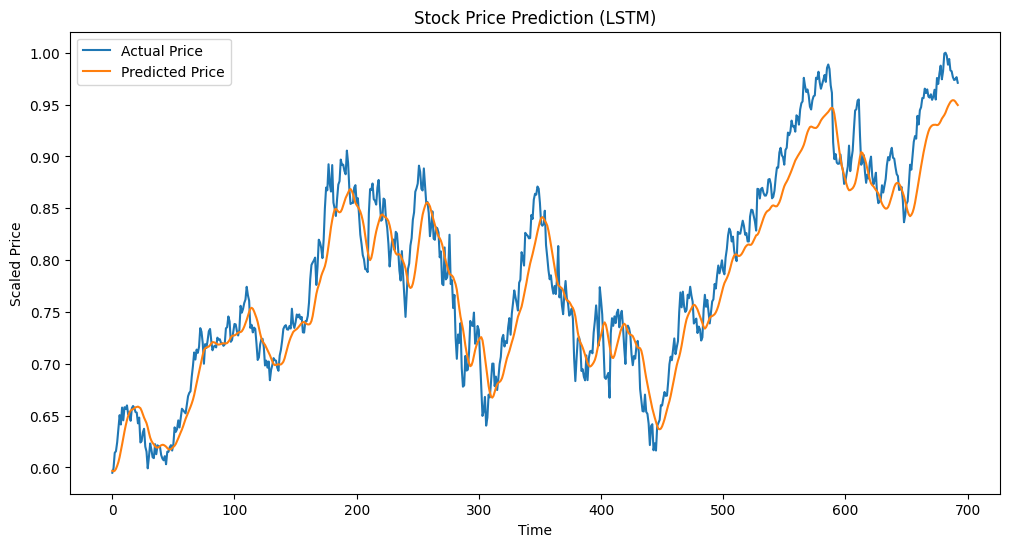

In [10]:
# Evaluate LSTM model
lstm_pred = evaluate_model(lstm_model, X_test, y_test, 'lstm')

In [11]:
# 5. Compare Models
def inverse_transform_predictions(y_true, y_pred, scaler):
    """Convert scaled predictions back to original price scale"""
    # Create dummy array with same shape as original features
    dummy = np.zeros((len(y_true), 5))
    dummy[:, 3] = y_true  # Close price is at index 3
    y_true_orig = scaler.inverse_transform(dummy)[:, 3]
    
    dummy[:, 3] = y_pred
    y_pred_orig = scaler.inverse_transform(dummy)[:, 3]
    
    return y_true_orig, y_pred_orig

# Convert to actual prices
y_test_orig, rf_pred_orig = inverse_transform_predictions(y_test, rf_pred, scaler)
_, lstm_pred_orig = inverse_transform_predictions(y_test, lstm_pred, scaler)

# Calculate percentage errors
rf_mape = np.mean(np.abs((y_test_orig - rf_pred_orig) / y_test_orig)) * 100
lstm_mape = np.mean(np.abs((y_test_orig - lstm_pred_orig) / y_test_orig)) * 100

print("\nModel Comparison (in original price scale):")
print(f"Random Forest MAPE: {rf_mape:.2f}%")
print(f"LSTM MAPE: {lstm_mape:.2f}%")


Model Comparison (in original price scale):
Random Forest MAPE: 13.97%
LSTM MAPE: 2.88%


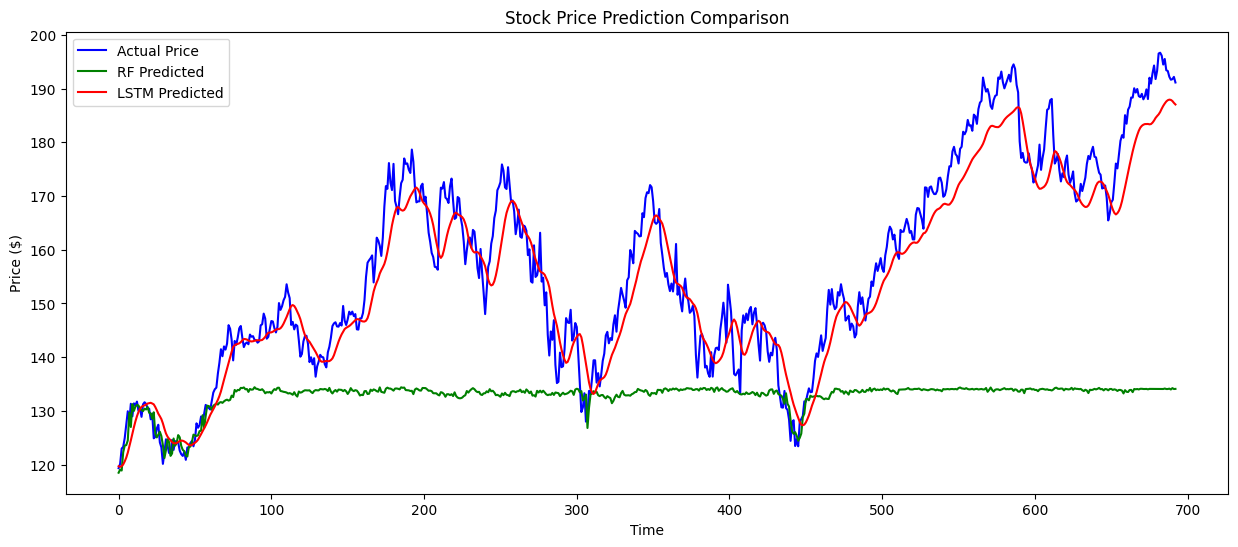

In [12]:
# Plot comparison
plt.figure(figsize=(15, 6))
plt.plot(y_test_orig, label='Actual Price', color='blue')
plt.plot(rf_pred_orig, label='RF Predicted', color='green')
plt.plot(lstm_pred_orig, label='LSTM Predicted', color='red')
plt.title('Stock Price Prediction Comparison')
plt.xlabel('Time')
plt.ylabel('Price ($)')
plt.legend()
plt.show()

In [13]:
# 6. Future Prediction Function
def predict_future_price(model, data, scaler, look_back=60, days=1, model_type='lstm'):
    """Predict stock price for future days (works for both LSTM and Random Forest)"""
    last_sequence = data[-look_back:]
    predictions = []
    
    for _ in range(days):
        # Prepare input
        if model_type == 'rf':
            input_data = last_sequence.reshape(1, look_back * 5)
            # For Random Forest, no verbose parameter
            pred = model.predict(input_data)[0]  # Get scalar prediction directly
        else:
            input_data = last_sequence.reshape(1, look_back, 5)
            # For LSTM, we can use verbose=0 to suppress output
            pred = model.predict(input_data, verbose=0)[0][0]  # Extract scalar value
        
        predictions.append(pred)
        
        # Update sequence
        new_row = np.zeros(5)
        new_row[3] = pred  # Update Close price
        last_sequence = np.vstack([last_sequence[1:], new_row])
    
    # Convert predictions to numpy array
    predictions = np.array(predictions)
    
    # Inverse transform predictions
    dummy = np.zeros((len(predictions), 5))
    dummy[:, 3] = predictions
    predictions_orig = scaler.inverse_transform(dummy)[:, 3]
    
    return predictions_orig

In [14]:
# Example: Predict next 5 days
scaled_full_data = scaler.transform(stock_data[['Open', 'High', 'Low', 'Close', 'Volume']].values)
next_days_lstm = predict_future_price(lstm_model, scaled_full_data, scaler, days=5)
next_days_rf = predict_future_price(rf_model, scaled_full_data, scaler, days=5, model_type='rf')

print("\nFuture Price Predictions:")
print(f"LSTM predictions for next 5 days: {next_days_lstm}")
print(f"RF predictions for next 5 days: {next_days_rf}")


Future Price Predictions:
LSTM predictions for next 5 days: [186.73070336 177.1937273  162.93068758 146.43371535 129.41208512]
RF predictions for next 5 days: [134.03608734  92.70801139  75.44012595  73.06206937  70.52010344]
